<font size="6">**MSc Data Science**</font>



<font size="3">**Name: Stamouli Maria (p3351820)**</font>

<font size="3">**Assignment 3: PageRank**</font>


<font size="3">**For this assignment we are going to refer to the below matrices with specific names. For part a and part b we use the notation:**</font>




**S:**         The boolean sparse matrix with 1 denotes link with other node and 0 otherwise.

**SS or P:**        The propability matrix that is the input of our dataset. It is very sparse and contains dangling nodes.

**P'' or G :** This matrix is dense, stochastic and primitive, referred as the Google matrix.

**α:**         Dumping factor between 0 and 1. For example: α=0.85 shows that a random surfer follows the hyperlink structure of the Web 85% of the time and teleports to a random new page 15% of the
time.

**πΤ:**        The pagerank vector we are looking for.

**a:**         The boolean dangling node vector which implies with 1 the existance of dangle node and 0 otherwise.

In [1]:
from scipy.sparse import csc_matrix,csr_matrix
import numpy as np

# change method to read
stanweb = np.loadtxt('stanweb.dat')
nodes = stanweb[len(stanweb)-1,0].astype(int)

#SS = csc_matrix((data[:,2], (data[:,0].astype(int)-1, data[:,1].astype(int)-1)), shape=(nodes, nodes))
SS = csr_matrix((stanweb[:,2], (stanweb[:,0].astype(int)-1, stanweb[:,1].astype(int)-1)), shape=(nodes, nodes))

print(SS.shape)

# convert matrix P with probabilities to adjacency matrix (with value 1 denoting link between the nodes and 0 otherwise)
S = SS.astype(bool).astype(np.int64)

(281903, 281903)


# Part a

In [2]:
import scipy as sp
from scipy import sparse
from scipy.sparse import  identity, tril, triu, eye, linalg, spdiags, vstack, hstack
from scipy.sparse.linalg import spsolve, spsolve_triangular

## Gauss Seidel method Formulation

**We write the matrix A of linear system as:** 

\begin{align}
A = I - α P 
\end{align}

**where P is the propability matrix derived from our initial dataset and I is the identity matrix**

**We can write matrix A as a diagonal matrix D, an upper triangular U with zeros in diagonal and a lower triangular L with zeros in the diagonal. We take advantage of the sparse functionality of scipy to store efficiently matrices with big size**


\begin{align}
A = D + L + U
\end{align}



**So the linear system Ax=b can be written iteratively:**

\begin{align}
(D + L + U)x = b
\end{align}

\begin{align}
(D + L)x + Ux = b
\end{align}

\begin{align}
(D + L)x_k+1 = b - U x_k
\end{align}

\begin{align}
x_k+1 = (D + L)^{-1} b - (D + L)^{-1} U x_k
\end{align}

**The component:**

\begin{align}
(D + L)^{-1} U 
\end{align}

**is the iteration matrix**

**Note that here b is the unitary vector normalized with n. The same holds for the initial value of xk(0).**

In [3]:
def gauss_seidel(P, alpha, tol):
  
     
    n=P.shape[0]
    A = identity(n, dtype=np.float64) - alpha*P
    A = A.T
    
    D = sparse.diags(A.diagonal())
    U = triu(A, format='csr', k=1)
    L = tril(A, format='csr',k=-1)
    D_L = D + L
   
    p0=sp.ones((n,1))/n
    pi= p0
    v = p0
    
    C = spsolve_triangular(D_L, v)    
    itr = 0
    error = 10000
        
    while error >= tol and itr<100:  
        
        itr +=1
        p_old = pi
        T = spsolve_triangular(D_L, U @ p_old)
        pi = -T+C
        error = np.linalg.norm(pi-p_old,1)/np.linalg.norm(pi,1)
        
    pi = pi/ np.sum(pi)  
    
    return pi, itr

## Power method Formulation

**Starting from the stationary equation:**

\begin{align}
π^T P'' = π^T 
\end{align}

**where P'' is the stochastic, irreducible, primitive matrix which guarantees the solution to the problem, we end up to implement the power method (see paragraph 5.1 of the paper), by using the below iterative relation to obtain the pagerank vector**

\begin{align}
x_k+1^T = α x_k^T P + (α x_k^T a + (1-α))v^T
\end{align}

**where α is the dumping factor between 0 and 1, a is the boolean vector that shows if a node is dangling or not and v is the unitary vector normalized with n**

In [4]:
def power_method_from_scratch(P, alpha, tol):
    
      
    n = P.shape[0]
    #dangling vector a 
    dangle = sp.array(sp.where(P.sum(axis=1) == 0, 1.0/n, 0))
    itr = 0
    pi0 = sp.ones((n,1))/n
    pi=pi0
    error = 1000    
    
    while (error >= tol):
        
        p_old = pi.reshape(1,n)
        itr +=1
        
        #aa = alpha*p_old @ P
        #bb = alpha*sp.dot(p_old,dangle)
        #cc = (1-alpha)*p_old.sum()/n
        #pi = aa + bb + cc
        
        pi = alpha*(p_old @ P + sp.dot(p_old,dangle)) + (1-alpha)*p_old.sum()/n        
        error = np.linalg.norm(pi-p_old)
    
    return pi.reshape(n,1), itr

## a) Find the vector π with:

**i) the Power method**

**ii) solving the corresponding system**

***as they described in paragraph 5.1 and 5.2 of the tutorial. For both methods consider as alpha = 0.85 and stopping criterion tol = 10^-8 and the vector a having 1 if it is corresponds to a node with no out links and 0 otherwise. Are the results the same for both methods? Which method seems to be faster? Use Gauss Seidel method for the iterative solution of the system. ***

**Alpha (dumbing factor): α = 0.85**

In [5]:
# Source: https://pypi.org/project/fast-pagerank/
# To run this cell first install:

#!pip install fast-pagerank
from fast_pagerank import pagerank_power,pagerank
import time

alpha = 0.85

start = time.process_time()

# Takes as input adjacency matrix S with 1 denoting a link between the nodes and 0 otherwise
pr_power = pagerank_power(S, p=alpha, personalize=None, tol=1e-8)
print('-------------------POWER METHOD--------------------------------------')
print()
print('Page ranking for the first 50 pages with power method:\n\n',pr_power.argsort(axis=0)[-50:][::-1].ravel()+1)
print()
print('Time for Power method with alpha=0.85:',time.process_time()-start)
print()

start = time.process_time()

pr_linear = pagerank(S, alpha)
print('-------------------LINEAR SYSTEM ------------------------------------')
print()
print('Page ranking for the first 50 pages with Linear Solving:\n\n',pr_linear.argsort(axis=0)[-50:][::-1].ravel()+1)
print()
print('Time for Linear Solving with alpha=0.85:',time.process_time()-start)

-------------------POWER METHOD--------------------------------------

Page ranking for the first 50 pages with power method:

 [ 89073 226411 241454 262860 134832 234704 136821  68889 105607  69358
  67756 225872 186750 272442 251796  95163 119479 231363  55788 167295
 179645  38342 117152 198090  60210 235496 132695 161890 112742 145892
 151428  81435  60440 208542     91 214128 258348 222873  27904 272762
  93778  96358 181701 247241 259455  34573 221087 183004 137632 176790]

Time for Power method with alpha=0.85: 4.453125

-------------------LINEAR SYSTEM ------------------------------------

Page ranking for the first 50 pages with Linear Solving:

 [ 89073 226411 241454 262860 134832 234704 136821  68889 105607  69358
  67756 225872 186750  95163 272442 251796 119479 231363  55788 167295
 179645  38342 117152 198090  60210 235496 132695 161890 112742 145892
 151428  81435  60440 208542     91 214128 258348 222873  27904 272762
  93778  96358 181701 259455 247241  34573 221087 13

## Implementation  (power method + Gauss Seidel)

In [6]:
import time

start = time.process_time()

pr_ , itr = power_method_from_scratch(SS, alpha, tol=1e-8)

print('-------------------POWER METHOD (FROM SCRATCH)------------------------------------')
print()
print('Page ranking for the first 50 pages with Power method:\n\n',pr_.argsort(axis=0)[-50:][::-1].ravel()+1)
print()
print('Time for Power method with alpha=0.85:',time.process_time()-start)
print('Iterations:',itr)
print()


start = time.process_time()

pr_gs, itr = gauss_seidel(SS, alpha, tol = 1e-8)
print('-------------------GAUSS SEIDEL -------------------------------------')
print()
print('Page ranking for the first 50 pages with iterative method Gauss Seidel:\n\n',pr_gs.argsort(axis=0)[-50:][::-1].ravel()+1)
print()
print('Time for Gauss Seidel with alpha=0.85:',time.process_time()-start)
print('Iterations:',itr)


-------------------POWER METHOD (FROM SCRATCH)------------------------------------

Page ranking for the first 50 pages with Power method:

 [ 89073 226411 241454 262860 134832 234704 136821  68889 105607  69358
  67756 225872 186750 272442  95163 251796 119479 231363  55788 167295
 179645  38342 117152 198090  60210 235496 132695 181701 247241 259455
 120708  62478 161890 176790 183004 137632  17781  77999 221087  96745
 112742 145892 151428  81435  60440 208542     91 214128 258348 222873]

Time for Power method with alpha=0.85: 3.046875
Iterations: 72

-------------------GAUSS SEIDEL -------------------------------------

Page ranking for the first 50 pages with iterative method Gauss Seidel:

 [ 89073 226411 241454 262860 134832 234704 136821  68889 105607  69358
  67756 225872 186750 272442 251796  95163 119479 231363  55788 167295
 179645  38342 117152 198090  60210 235496 132695 181701 259455 247241
 120708  62478 161890 221087 183004 176790 137632  77999  17781  96745
 112742 1

## *Conclusion about question (a):*

**About similarity of ranking**

<font size="3">*Taking into consideration the first 50 nodes, the results have some small differences among the methods.  Moreover the first positions in ranking are pretty much the same.*</font>


**About speed**

<font size="3">*In general we expect that Gauss-Seidel method should be faster, because iterative methods can handle much more efficiently sparse matrices. Moreover, in this case it takes much more time for multiplications of the matrices in comparison to Power method because the implementation presented in the notebook is not optimized.*</font>

## b) Do the previous task with alpha = 0.99. Your remarks on the convergence speed. Did the ranking of the first 50 nodes changed?



**Alpha (dumbing factor): α = 0.99**

**Stopping criterion (tolerance):  τ = 10^(-8)  & max iterations = 100** 


In [7]:
# Source: https://pypi.org/project/fast-pagerank/
# First install:

#!pip install fast-pagerank
from fast_pagerank import pagerank_power,pagerank

import time

alpha = 0.99

start = time.process_time()

pr_power99 = pagerank_power(S, p=alpha, personalize=None, tol=1e-8)
print('-------------------POWER METHOD--------------------------------------')
print()
print('Page ranking for the first 50 pages with power method:\n\n',pr_power99.argsort(axis=0)[-50:][::-1].ravel()+1)
print()
print('Time for Power method with alpha=0.99',time.process_time()-start)
print()

start = time.process_time()

pr_linear99 = pagerank(S, alpha)
print('-------------------LINEAR SYSTEM ------------------------------------')
print()
print('Page ranking for the first 50 pages with Linear Solving:\n\n',pr_linear99.argsort(axis=0)[-50:][::-1].ravel())
print()
print('Time for Linear Solving with alpha=0.99:',time.process_time()-start)
print()


-------------------POWER METHOD--------------------------------------

Page ranking for the first 50 pages with power method:

 [ 89073 281772 174665 226411 179645 262860 271409 136821  68889  65580
 272442 251796  95163 241454 119479  77084  77988 116530  14785 117152
 245765  58048 152337 235496 229580  95366 181701 247241 259455  77999
 221087  17781 137632 183004 176790  96745  62478 120708  27904 272762
 253495  20343 234704  75417 257610 192120 119822  98593 193134 204564]

Time for Power method with alpha=0.99 5.1875

-------------------LINEAR SYSTEM ------------------------------------

Page ranking for the first 50 pages with Linear Solving:

 [ 89072 281771 174664 226410 179644 271408 262859 136820  68888  77987
 116529 251795  95162 272441  65579 119478 241453 245764  58047  14784
  77083 117151 152336 235495 119821 181700 247240 259454  77998  17780
 221086 183003 176789 137631  96744  62477 120707  27903 272761  96195
 229579  95365 234961 169233 144493 236643 275884  8503

In [8]:
import time

start = time.process_time()

pr_99 , itr = power_method_from_scratch(SS, alpha, tol=1e-8)

print('-------------------POWER METHOD (FROM SCRATCH)------------------------------------')
print()
print('Page ranking for the first 50 pages with Power method:\n\n',pr_99.argsort(axis=0)[-50:][::-1].ravel())
print()
print('Time for Power method with alpha=0.99:',time.process_time()-start)
print('Iterations:',itr)
print()


start = time.process_time()

pr_gs99, itr = gauss_seidel(SS, alpha, tol = 1e-8)
print('-------------------GAUSS SEIDEL -------------------------------------')
print()
print('Page ranking for the first 50 pages with iterative method Gauss Seidel:\n\n',pr_gs99.argsort(axis=0)[-50:][::-1].ravel()+1)
print()
print('Time for Gauss Seidel with alpha=0.99:',time.process_time()-start)
print('Iterations:',itr)
print()

-------------------POWER METHOD (FROM SCRATCH)------------------------------------

Page ranking for the first 50 pages with Power method:

 [ 89072 281771 174664 226410 179644 271408 262859 136820  68888  77987
 116529  95162 272441 251795  65579 119478 241453 245764  58047  14784
  77083 117151 152336 181700 235495 247240 259454 120707  62477 221086
  17780 137631 176789  77998 183003  96744 119821  27903 272761  96195
 229579  95365 169233 234961 264186  85039  49046  58611 144493 236643]

Time for Power method with alpha=0.99: 47.359375
Iterations: 1141

-------------------GAUSS SEIDEL -------------------------------------

Page ranking for the first 50 pages with iterative method Gauss Seidel:

 [ 89073 281772 174665 226411 179645 262860 271409 136821  68889  65580
 272442 241454 251796  95163 119479  77988 116530  77084  14785 245765
 117152  58048 181701 235496 259455 247241 120708 221087  62478 183004
 176790 137632  96745  77999  17781 152337 229580  95366 272762  27904
 23470

## *Conclusions about question (b)*



**About similarity of ranking**

<font size="3">*Taking into consideration the first 50 nodes, with bigger a (=0.99), we notice that the ranking is more sensitive to give different results. The results have some bigger differences among the methods. Moreover the first positions in ranking are pretty much the same.*</font>


**About speed**

<font size="3">*In general we expect that Gauss-Seidel method should be faster, because iterative methods can handle much more efficiently sparse matrices. Moreover, in this case it takes much more time for multiplications of the matrices in comparison to Power method because the implementation presented in the notebook is not optimized.*</font>


**General notice**

<font size="3">*If we compare ranking results between a = 0.85 and a = 0.99, we can observe that the ranking is not the same exactly (except from the first node). So, obviously, different alphas lead to different rankings. We should also notice that for a = 0.99 we set a maximum number of iterations in Gauss-Seidel method, because it takes too much time to converge. So, with maximum 100 iterations, the results that we take from Gauss-Seidel method are close to the results of power method.*</font>

## c) When we use the power method do all the components of π converge at the same speed to their limits? If not which of the converge faster: those that correspond to important nodes or to non important ? Do you observe the same behavior when you find π through the solution of the linear system?

### Answer:

<font size="3">**For an implementation of these approach we can refer to a slightly different method of Power Method, that is known as "Adaptive Power method".**</font>

<font size="3">*The general idea of this method is that we have to take advantage of the elements that converge faster and put them in a different group. Specifically: We can look at individual components in the two vectors, examining how far π(k)^i is from πi at each iteration. This technique is implemented in the paper of source (3) "Adaptive Methods for the Computation of PageRank". The results noticed that some pages converge to their PageRank values faster than other pages as mentioned in.For more information about that method see source (1): Beyond PageRank page 89 and paper of source (3).*</font>

In [137]:
def power_method_identify_convergence(P, alpha, tol):
    
    conv_error = []
    conv_iter = []
    
    n = P.shape[0]
    dangle = sp.array(sp.where(P.sum(axis=1) == 0, 1.0/n, 0))
    itr = 0
    pi0 = sp.ones((n,1))/n
    pi=pi0
    error = 1000    
    page = []
    
    while (error >= tol):
        
        p_old = pi.reshape(1,n)
        itr +=1        
        pi = alpha*(p_old @ P + sp.dot(p_old,dangle)) + (1-alpha)*p_old.sum()/n        
        error = np.linalg.norm(pi-p_old,1) / np.linalg.norm(p_old,1) 
        
        #convergence error
        er = (abs(pi-p_old)/p_old).ravel()          
        
        for i in range(5000):
            
            if (er[i] <= 1e-3) & (i not in page):
                
                page.append(i)
                conv_error.append(er[i])
                conv_iter.append(itr)
    
    return pi.reshape(n,1), itr, conv_error, conv_iter

In [138]:
rank,itr,conv_error,conv_iter =  power_method_identify_convergence(SS, 0.85, 1e-8)

In [139]:
from collections import Counter
Counter(np.asarray(conv_iter))

Counter({1: 266,
         2: 448,
         3: 102,
         4: 117,
         5: 132,
         6: 291,
         7: 338,
         8: 292,
         9: 588,
         10: 411,
         11: 264,
         12: 169,
         13: 289,
         14: 182,
         15: 131,
         16: 135,
         17: 110,
         18: 125,
         19: 111,
         20: 103,
         21: 72,
         22: 47,
         23: 26,
         24: 29,
         25: 11,
         26: 11,
         27: 9,
         28: 12,
         29: 10,
         30: 32,
         31: 8,
         32: 11,
         33: 7,
         34: 12,
         35: 10,
         36: 12,
         37: 6,
         38: 14,
         39: 11,
         40: 11,
         41: 9,
         42: 6,
         43: 2,
         44: 2,
         45: 6,
         46: 5,
         47: 5})

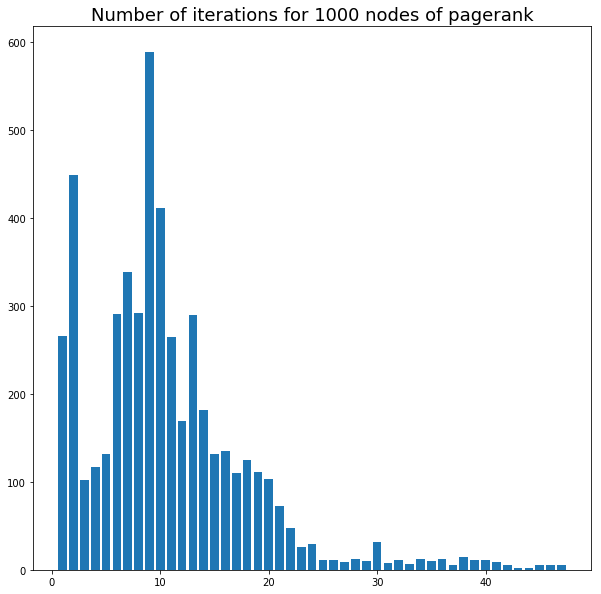

In [140]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
plt.title('Number of iterations for 1000 nodes of pagerank',fontsize=18)
labels, values = zip(*Counter(np.asarray(conv_iter)).items())

plt.bar(labels,values)
plt.show()

## *Conclusions about question (c)*

<font size="5">**Strategy:** </font> 

<font size="3">*Inside the Power Method we run a for loop for 5000 nodes of the pagerank vector and compute the absolute relative error. If this error is smaller than tol=1e-3, then we conclude that this specific node has converged*</font>

\begin{align}
|x (k+1) - x (k)| / |x (k)| < 1e-3
\end{align}

<font size="5">**Findings:**</font> 

<font size="3">*We count the results and observe that the most of the nodes need more iterations until convergence. To identify them we should implement a sorting in the most important ones so as to see if they need more iterations, as claimed in the paper. This is not implemented above but this is the main idea.*</font> 

# Part b

## a) You now create a new web page X (thus adding a node to the web graph). X has neither in-links, nor out-links. Let π’ = (π1’, π2’, .... , πn’)  denote the vector of new PageRanks of the n old web pages, and x denote the new PageRank of page X: In other words, π’ = (π1’, π2’, .... , πn’, x)  is the PageRank vector of the new web graph. Write π' and x in terms of r: Comment on how the PageRanks of the older pages changed due to the addition of the new page (remember n is a very large number). Hint: Use the stationary equations to calculate PageRank, not the iterative approach.

### Answer:

**We approach this problem by solving the stationary equations (paragraph 5.1), which is the eigenvector problem (power method), as mentioned in both sources (1), (2). We start from the equation:**

\begin{align}
π^T G = π^T 
\end{align}

**The Google matrix here is the stochastic, irreducible and primitive matrix. For more information see source (1).**

**We create a new web page X and add it to our initial graph. Since the node has nor outlinks or inlinks we add a zero row and a zero column to our initial matrix from our dataset (propability sparse matrix). This should not be a problem because by implementing the power method, we handle the dangle nodes as in part a (with a dangling vector a).**

In [73]:
def pagerank_linear_system(A, a=0.85):

    n, _ = A.shape
    r = sp.asarray(A.sum(axis=1)).reshape(-1)

    k = r.nonzero()[0]

    D_1 = csr_matrix((1 / r[k], (k, k)), shape=(n, n))

    v = sp.ones(n)
    v = v.reshape(n, 1)
    s = (v / v.sum()) * n

    I = eye(n)
    x = spsolve((I - a * A.T @ D_1), s)

    x = x / x.sum()
    return x

In [151]:
n=SS.shape[0]

row = csr_matrix(np.zeros((1, n))) # add row with zeros
col = csr_matrix(np.zeros((n+1,1))) # add column with zeros

SS_row = vstack((SS, row))
SS_new = hstack((SS_row, col))


print('The shape of new propability matrix is:', SS_new.shape)
pr_new_a = pagerank_linear_system(SS_new.astype(bool).astype(np.int64), a=0.85)


print('The new Pagerank is:\n\n',pr_new_a.argsort(axis=0)[-50:][::-1].ravel()+1)
unchanged = np.where((pr_new_a.argsort(axis=0)[-50:][::-1].ravel()+1 == pr_new_a.argsort(axis=0)[-50:][::-1].ravel()+1))
print('The unchanged rankings are:',unchanged[0].shape)
print()
print('For the first 50 nodes the positions that did not change at all are:\n\n',unchanged[0])


import pandas as pd
compare_pagerank = pd.DataFrame(data=[pr_new_a.argsort(axis=0)[-50:][::-1].ravel(), pr_new_a.argsort(axis=0)[-50:][::-1].ravel()]).T.rename(columns={0:'PR_new',1:'PR_old'})
compare_pagerank

The shape of new propability matrix is: (281904, 281904)
The new Pagerank is:

 [ 89073 226411 241454 262860 134832 234704 136821  68889 105607  69358
  67756 225872 186750  95163 251796 272442 119479 231363  55788 167295
 179645  38342 117152 198090  60210 235496 132695 161890 112742 145892
 151428  81435  60440 208542     91 214128 258348 222873  27904 272762
  93778  96358 181701 247241 259455  34573 221087 137632 176790 183004]
The unchanged rankings are: (50,)

For the first 50 nodes the positions that did not change at all are:

 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]


,PR_new,PR_old
0,89072,89072
1,226410,226410
2,241453,241453
3,262859,262859
4,134831,134831
5,234703,234703
6,136820,136820
7,68888,68888
8,105606,105606
9,69357,69357


In [167]:
print('The pagerank value of webpage X is:',pr_new_a[-1])
filter_pages = np.where(np.sort(pr_new_a,axis=0) > pr_new_a[-1])
print('The web page is in the last:', filter_pages[0][0], 'results')

The pagerank value of webpage X is: 5.333682877488961e-07
The web page is in the last: 20316 results


## *Conclusions about question (a):*



<font size="3">*Looking at the first 50 nodes (as in part A), we notice that the new page ranking (after we add a new web page), has some small changes regarding the positions. That means a node that was in the 14th ranking, with the new page rank was moved to 15th ranking. We do not consider it as a substantial change in the whole ranking. So we conclude that the initial PageRanking is pretty much the same with the new PageRanking. This happens because the new webpage added has no connections with the other pages, so it does not affect our PageRank vector.*</font>



## b) Unsatised with the PageRank of your page X; you create another page Y (with no in-links) that links to X: What are the PageRanks of all the n + 2 pages now? Does the PageRank of X improve?


In [184]:
n=SS.shape[0]

row = csr_matrix(np.zeros((1, n))) # add row with zeros
col = csr_matrix(np.zeros((n+1,1))) # add column with zeros

SS_row = vstack((SS, row))
SS_new = hstack((SS_row, col))
# add link
SS_new = SS_new.tocsr()
SS_new[0, pr_new_a[-1]] = 1

print('The shape of new propability matrix is:', SS_new.shape)
pr_new_a = pagerank_linear_system(SS_new.astype(bool).astype(np.int64), a=0.85)


print('The new Pagerank is:\n\n',pr_new_a.argsort(axis=0)[-50:][::-1].ravel()+1)
unchanged = np.where((pr_new_a.argsort(axis=0)[-50:][::-1].ravel()+1 == pr_new_a.argsort(axis=0)[-50:][::-1].ravel()+1))
print('The unchanged rankings are:',unchanged[0].shape)
print()
print('For the first 50 nodes the positions that did not change at all are:\n\n',unchanged[0])


import pandas as pd
compare_pagerank = pd.DataFrame(data=[pr_new_a.argsort(axis=0)[-50:][::-1].ravel(), pr_new_a.argsort(axis=0)[-50:][::-1].ravel()]).T.rename(columns={0:'PR_new',1:'PR_old'})
compare_pagerank

C:\Users\Maria\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  # Remove the CWD from sys.path while we load stuff.


The shape of new propability matrix is: (281904, 281904)
The new Pagerank is:

 [ 89073 226411 241454 262860 134832 234704 136821  68889 105607  69358
  67756 225872 186750  95163 251796 272442 119479 231363  55788 167295
 179645  38342 117152 198090  60210 235496 132695 161890 112742 145892
 151428  81435  60440 208542     91 214128 258348 222873  27904 272762
  93778  96358 181701 247241 259455  34573 221087 137632 176790 183004]
The unchanged rankings are: (50,)

For the first 50 nodes the positions that did not change at all are:

 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]


,PR_new,PR_old
0,89072,89072
1,226410,226410
2,241453,241453
3,262859,262859
4,134831,134831
5,234703,234703
6,136820,136820
7,68888,68888
8,105606,105606
9,69357,69357


In [185]:
print('The pagerank value of webpage X is:',pr_new_a[-1])
filter_pages = np.where(np.sort(pr_new_a,axis=0) > pr_new_a[-1])
print('The web page is in the last:', filter_pages[0][0], 'results')

The pagerank value of webpage X is: 5.333682877488961e-07
The web page is in the last: 20315 results


In [186]:
print('The position changed only by one')

The position changed only by one


## The next are not implemented but the main idea is presented

## c) Still unsatisied, you create a third page Z: How should you set up the links on your three pages so as to maximize the PageRank of X?

### Answer:

<font size="5">**Strategy:** </font> 

<font size="3">*When one page links to another page, it is effectively casting a vote for the other page. More votes imply more importance. Here we have 2 differents pages (Y and Z) which link to the our web page X. So if Y and Z link to X, we believe that these votes will improve the pagerank of X.*</font> 


## d) You have one last idea, you add links from your page X to older, popular pages (e.g.: you add a list of ?Useful links? on your page). Does this improve the PageRank of X? Does the answer change if you add links from Y or Z to older, popular pages?

### Answer:

<font size="5">**Strategy:** </font>

**When one page links to another page, it is effectively casting a vote for the other page. Also, more votes imply more importance.** 



The above was implemented in question (c)--Moreover the links that we added where not important! (they were not in high ranking)


<font size="5">**IMPORTANCE:**</font>


**Importance of the page that is casting the vote determines the importance of the vote.  A web page is important if it is pointed to by other important web pages.** 

<font size="3">**So if we try to link important nodes (e.g. the first 5 nodes) with our webpage X, we will see that the pagerank will improve**</font>

**Sources:**

(1)	http://geza.kzoo.edu/~erdi/patent/langvillebook.pdf (Beyond PageRank)

(2)	Deeper Inside PageRank, Amy N. Langville and Carl D. Meyer

(3) Adaptive Methods for the Computation of PageRank

(4) Fast PageRank: https://pypi.org/project/fast-pagerank/

(5) Iterative methods: http://www.robots.ox.ac.uk/~sjrob/Teaching/EngComp/linAlg34.pdf

(6) https://www.csie.ntu.edu.tw/~azarc/sna/networkx/networkx/algorithms/pagerank.py

(7) https://www.mathworks.com/content/dam/mathworks/mathworks-dot-com/moler/exm/chapters/pagerank.pdf

## Source code (Fast PageRank)

``` 
"""Two fast implementations of PageRank:
    An exact solution using a sparse linear system solver,
    and an a power method approximation.
    Both solutions are taking full advantage of sparse matrix calculations.
    [Reference]:
    Cleve Moler. 2011. Experiments with MATLAB (Electronic ed.).
    MathWorks, Inc.
"""
# uncomment
from __future__ import division

import scipy as sp
import scipy.sparse as sprs
import scipy.spatial
import scipy.sparse.linalg

__author__ = "Armin Sajadi"
__copyright__ = "Copyright 2015, The Wikisim Project"
__email__ = "asajadi@gmail.com"


def pagerank(A, p=0.85,
             personalize=None, reverse=False):
    """ Calculates PageRank given a csr graph
    Inputs:
    -------
    G: a csr graph.
    p: damping factor
    personlize: if not None, should be an array with the size of the nodes
                containing probability distributions.
                It will be normalized automatically
    reverse: If true, returns the reversed-PageRank
    outputs
    -------
    PageRank Scores for the nodes
    """
    # In Moler's algorithm, $A_{ij}$ represents the existences of an edge
    # from node $j$ to $i$, while we have assumed the opposite!
    if reverse:
        A = A.T

    n, _ = A.shape
    r = sp.asarray(A.sum(axis=1)).reshape(-1)

    k = r.nonzero()[0]

    D_1 = sprs.csr_matrix((1 / r[k], (k, k)), shape=(n, n))

    if personalize is None:
        personalize = sp.ones(n)
    personalize = personalize.reshape(n, 1)
    s = (personalize / personalize.sum()) * n

    I = sprs.eye(n)
    x = sprs.linalg.spsolve((I - p * A.T @ D_1), s)

    x = x / x.sum()
    return x


def pagerank_power(A, p=0.85, max_iter=100,
                   tol=1e-06, personalize=None, reverse=False):
    """ Calculates PageRank given a csr graph
    Inputs:
    -------
    A: a csr graph.
    p: damping factor
    max_iter: maximum number of iterations
    personlize: if not None, should be an array with the size of the nodes
                containing probability distributions.
                It will be normalized automatically.
    reverse: If true, returns the reversed-PageRank
    Returns:
    --------
    PageRank Scores for the nodes
    """
    # In Moler's algorithm, $G_{ij}$ represents the existences of an edge
    # from node $j$ to $i$, while we have assumed the opposite!
    if reverse:
        A = A.T

    n, _ = A.shape
    r = sp.asarray(A.sum(axis=1)).reshape(-1)

    k = r.nonzero()[0]

    D_1 = sprs.csr_matrix((1 / r[k], (k, k)), shape=(n, n))

    if personalize is None:
        personalize = sp.ones(n)
    personalize = personalize.reshape(n, 1)
    s = (personalize / personalize.sum()) * n

    z_T = (((1 - p) * (r != 0) + (r == 0)) / n)[sp.newaxis, :]
    W = p * A.T @ D_1

    x = s
    oldx = sp.zeros((n, 1))

    iteration = 0

    while sp.linalg.norm(x - oldx) > tol:
        oldx = x
        x = W @ x + s @ (z_T @ x)
        iteration += 1
        if iteration >= max_iter:
            break
    x = x / sum(x)

    return x.reshape(-1)
```